In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression

### Extraction Features

In [2]:
df = pd.read_csv("../PreProcessingResumes/processed_data/Resume_stopword_lemm.csv")
df.head()

,ID,Resume_str,Category
0,16852973,hr administrator marketing associate hr admini...,HR
1,22323967,hr specialist u hr operation summary versatile...,HR
2,33176873,hr director summary year experience recruiting...,HR
3,27018550,hr specialist summary dedicated driven dynamic...,HR
4,17812897,hr manager skill highlight hr skill hr departm...,HR


In [3]:
# TF-IDF vectorizer that converts a collection of raw text documents into a matrix of TF-IDF features
tfidf_vect = TfidfVectorizer(
    lowercase=True,         # Convert all text to lowercase
    binary=False,           # Use term frequency, not just presence/absence
    max_features=10000,     # Keep only the top 10,000 most frequent terms
    ngram_range=(1, 3),     # Extract n-grams
    max_df=0.8,             # Ignore terms that appear in more than 80% of documents
    min_df=2                # Ignore terms that appear in fewer than 2 documents
)

In [4]:
# Split data into training and test sets. The split is stratified to maintain the distribution of categories
X_train, X_test, y_train, y_test = train_test_split(df['Resume_str'], df['Category'], test_size=0.2, random_state=42, stratify=df['Category'])

print("Train data size:", X_train.shape)
print("Validation data size:", X_test.shape)

Train data size: (1986,)
Validation data size: (497,)


Transform the training and test data into TF-IDF feature matrices.  
X_train is fitted and transformed, while X_test is only transformed using the already fitted vectorizer.

In [5]:
X_train_features = tfidf_vect.fit_transform(X_train)
X_test_features = tfidf_vect.transform(X_test)

### Logistic Regression Classifier

In [6]:
def report(results, n_top=10, primary_metric='f1_weighted', secondary_metric='accuracy'):

    rank_key = f"rank_test_{primary_metric}"
    mean_key = f"mean_test_{primary_metric}"
    std_key = f"std_test_{primary_metric}"
    secondary_key = f"mean_test_{secondary_metric}"
    
    for rank in range(1, n_top + 1):

        candidates = np.flatnonzero(results[rank_key] == rank)
        for c in candidates:
            print(f"Model with rank: {rank}")
            print(f"Mean validation {primary_metric}: {results[mean_key][c]:.3f} (std: {results[std_key][c]:.3f})")
            
            if secondary_key in results:
                print(f"Mean validation {secondary_metric}: {results[secondary_key][c]:.3f}")
            
            print("Parameters:", results["params"][c])
            print("")

In [7]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=4)),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

In [9]:
param_grid = [
    {
        'clf__C': [0.01, 0.1, 1, 10],
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs']
    }
]

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring= ['accuracy', 'f1_weighted'],
    refit = 'f1_weighted',
    return_train_score=True,
    n_jobs=5
)

start = time()
grid_search = grid.fit(X_train_features, y_train)

print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_['params'])} candidates parameter settings.\n")
report(grid_search.cv_results_)

GridSearchCV took 17.13 seconds for 4 candidates parameter settings.

Model with rank: 1
Mean validation f1_weighted: 0.702 (std: 0.015)
Mean validation accuracy: 0.707
Parameters: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

Model with rank: 2
Mean validation f1_weighted: 0.696 (std: 0.016)
Mean validation accuracy: 0.700
Parameters: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

Model with rank: 3
Mean validation f1_weighted: 0.654 (std: 0.015)
Mean validation accuracy: 0.670
Parameters: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

Model with rank: 4
Mean validation f1_weighted: 0.637 (std: 0.012)
Mean validation accuracy: 0.656
Parameters: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}



In [10]:
print("Best hyperparameters found:")
for name, val in grid_search.best_params_.items():
    print(f" - {name}: {val}")

Best hyperparameters found:
 - clf__C: 10
 - clf__penalty: l2
 - clf__solver: lbfgs


In [11]:
LR_Model_best = grid_search.best_estimator_
prediction = LR_Model_best.predict(X_test_features)

In [12]:
print("Training Score: {:.2f}".format(LR_Model_best.score(X_train_features, y_train)))
print("Test Score: {:.2f}".format(LR_Model_best.score(X_test_features, y_test)))

Training Score: 1.00
Test Score: 0.72


In [13]:
print(classification_report(y_test, prediction, zero_division=0))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.84      0.93      0.88        28
              ADVOCATE       0.53      0.62      0.57        13
           AGRICULTURE       0.60      0.50      0.55         6
               APPAREL       0.69      0.82      0.75        11
                  ARTS       1.00      0.20      0.33         5
            AUTOMOBILE       0.00      0.00      0.00         2
              AVIATION       0.68      0.79      0.73        19
               BANKING       0.70      0.41      0.52        17
                   BPO       0.25      0.20      0.22        10
  BUSINESS-DEVELOPMENT       0.61      0.66      0.63        35
                  CHEF       0.82      0.90      0.86        20
          CONSTRUCTION       0.94      0.77      0.85        22
            CONSULTANT       0.47      0.38      0.42        24
              DESIGNER       0.81      0.95      0.88        22
         DIGITAL-MEDIA       0.71      

<Figure size 1500x1000 with 0 Axes>

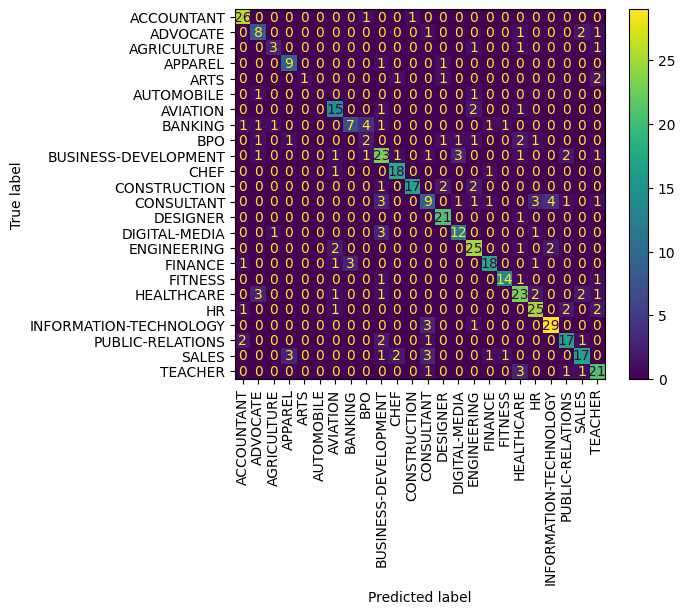

In [14]:
plt.figure(figsize=(15, 10))  # Imposta la dimensione della figura
ConfusionMatrixDisplay.from_predictions(y_test, prediction)
plt.xticks(rotation=90)
plt.show()

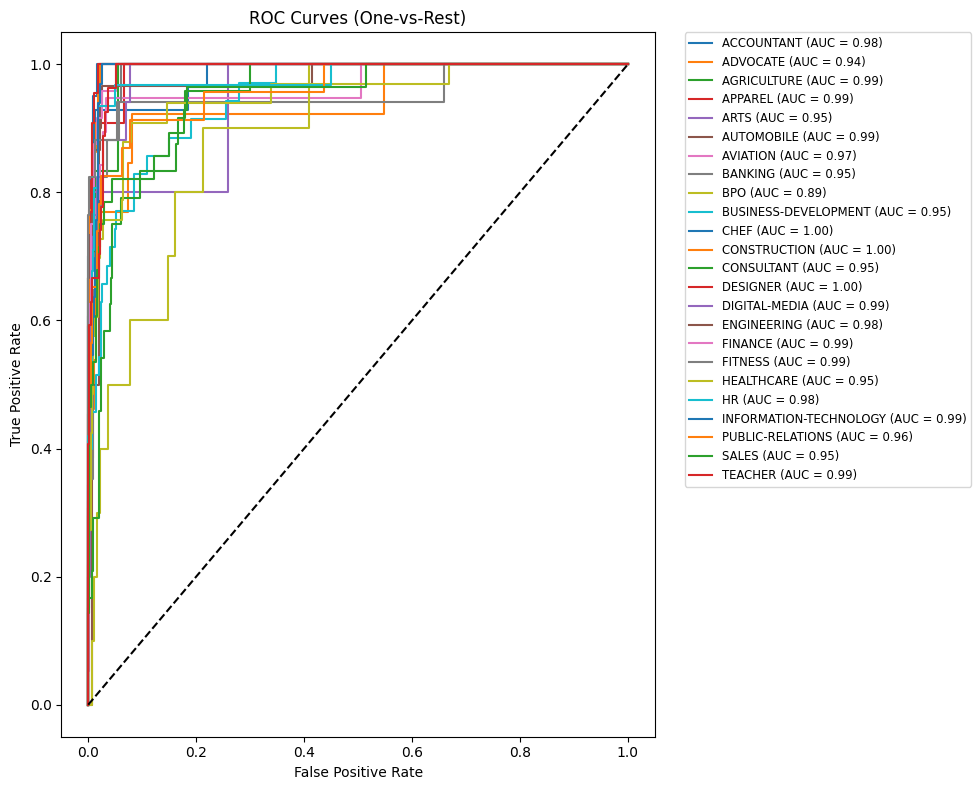

In [15]:
y_test_bin = label_binarize(y_test, classes=LR_Model_best.classes_)
y_score = LR_Model_best.predict_proba(X_test_features)

plt.figure(figsize=(10, 8))

for i in range(len(LR_Model_best.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{LR_Model_best.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")

# Sposta la legenda fuori dal grafico
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')
plt.tight_layout()
plt.show()

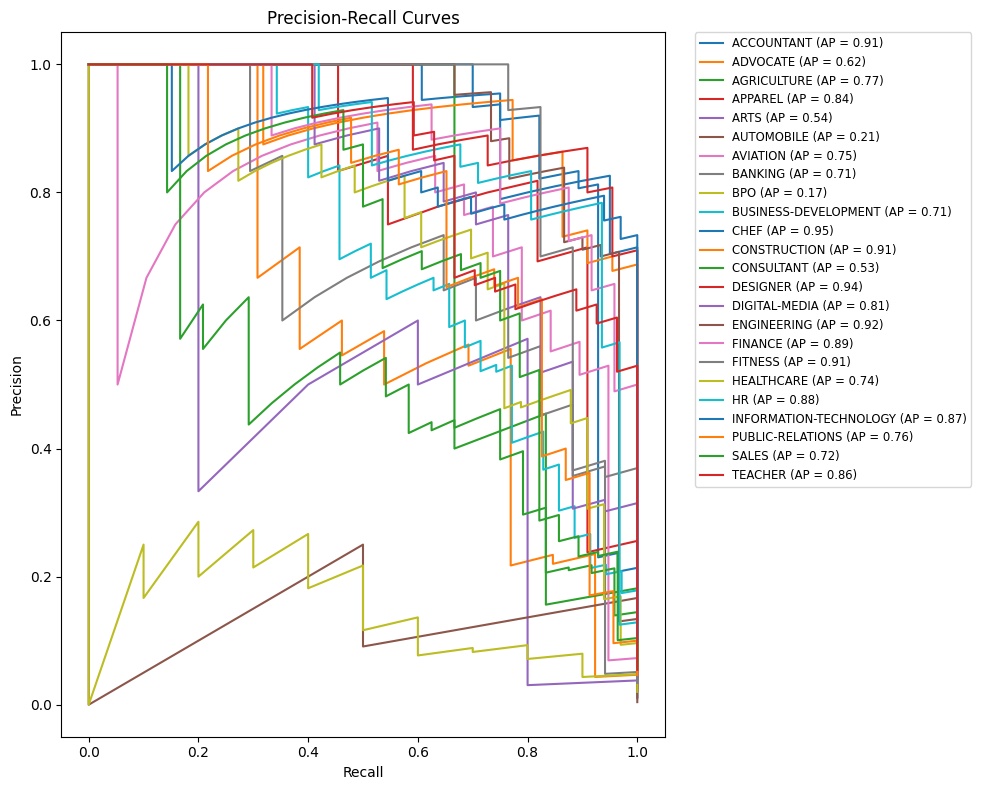

In [16]:
plt.figure(figsize=(10, 8))

for i in range(len(LR_Model_best.classes_)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f"{LR_Model_best.classes_[i]} (AP = {avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")

# Legenda esterna a destra
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')
plt.tight_layout()
plt.show()

In [17]:
import sys
sys.path.append('..')

from utils import save_experiment_TFIDF

save_experiment_TFIDF(tfidf_vect, grid_search, LR_Model_best, X_train_features, y_train, X_test_features, y_test)

✅ Riga di log aggiunta in 'experiment_log.txt':
LogisticRegression(clf__C=10, clf__penalty=l2, clf__solver=lbfgs) | TFIDF(max_features=10000, ngram_range=(1, 3), max_df=0.8, min_df=2) | Accuracy train=1.000, test=0.724

